In [1]:
# Our objective is mixup augmentation on cats vs dogs dataset using pytorch

In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
train_path = "/home/rishabh.mondal/label_image_FT"

In [3]:
def class_label(train_path):
    class_labels = {"cat": 0, "dog": 1}
    image_paths = []
    labels = []
    for class_name, class_label in class_labels.items():
        class_dir = os.path.join(train_path, class_name)
        class_image_paths = glob.glob(os.path.join(class_dir, "*.jpg"))
        image_paths.extend(class_image_paths)
        labels.extend([class_label] * len(class_image_paths))
    return image_paths, labels

In [4]:
import random


def display_images(image_paths, labels):
    fig, axes = plt.subplots(2, 2, figsize=(5, 4))
    data = list(zip(image_paths, labels))
    random.shuffle(data)
    image_paths, labels = zip(*data)
    for i in range(4):
        ax = axes[i // 2, i % 2]
        img = cv2.imread(image_paths[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title("Label: " + str(labels[i]))
        ax.axis("off")

    plt.tight_layout()

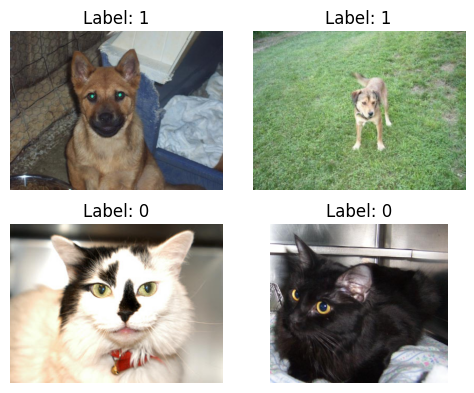

In [5]:
image_paths, labels = class_label(train_path)
display_images(image_paths, labels)

In [7]:
data = list(zip(image_paths, labels))
print(data[9])
image_paths, labels = zip(*data)
print(data[0])
print(image_paths[9])
print(labels[9])

# tranform the two image into same size

('/home/rishabh.mondal/label_image_FT/cat/78.jpg', 0)
('/home/rishabh.mondal/label_image_FT/cat/194.jpg', 0)
/home/rishabh.mondal/label_image_FT/cat/78.jpg
0


In [8]:
def mixup_augmentation_between_two_image(image1, image2, alpha):
    beta = np.random.beta(alpha, alpha)
    beta = max(beta, 1 - beta)
    image1 = np.asarray(image1).astype(np.float32)
    image2 = np.asarray(image2).astype(np.float32)
    mixed_image = beta * image1 + (1 - beta) * image2
    mixed_image = mixed_image.astype(np.uint8)
    return mixed_image

In [9]:
def resize_images(image1_path, image2_path, size=(224, 224)):
    image1 = cv2.imread(image1_path)
    image1_resized = cv2.resize(image1, size)

    image2 = cv2.imread(image2_path)
    image2_resized = cv2.resize(image2, size)

    return image1_resized, image2_resized

In [46]:
img1, img2 = resize_images(image_paths[2], image_paths[17])

In [47]:
img1.shape

(224, 224, 3)

In [48]:
# mixup_augmentation_between_two_image(img1,img2,0.2) and label
def mixup_augmentation(img1, img2, label1, label2, alpha):
    beta = np.random.beta(alpha, alpha)
    beta = max(beta, 1 - beta)
    img1 = np.asarray(img1).astype(np.float32)
    img2 = np.asarray(img2).astype(np.float32)
    mixed_image = beta * img1 + (1 - beta) * img2
    mixed_label = beta * label1 + (1 - beta) * label2
    mixed_image = mixed_image.astype(np.uint8)
    return mixed_image, mixed_label

0.4192032706924733


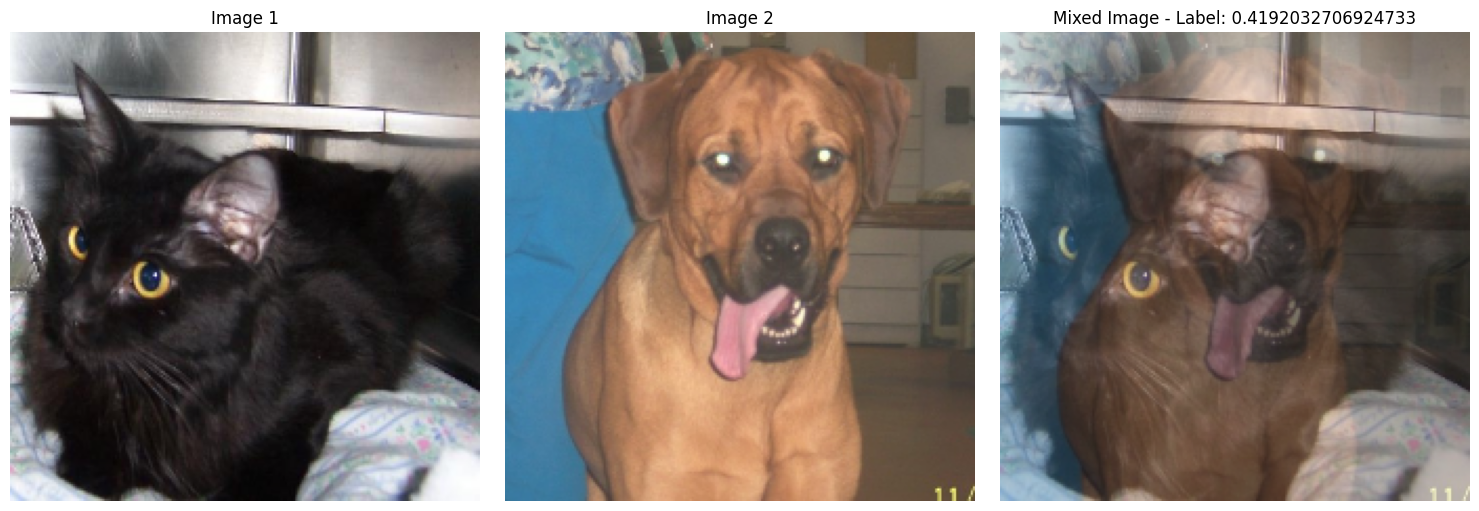

In [49]:
mixed_image, mixup_label = mixup_augmentation(img1, img2, labels[0], labels[10], 0.5)
print(mixup_label)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Image 1")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image 2")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(mixed_image, cv2.COLOR_BGR2RGB))
axes[2].set_title("Mixed Image - Label: " + str(mixup_label))
axes[2].axis("off")

plt.tight_layout()

In [50]:
# import transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
train_data = datasets.ImageFolder(
    "/home/rishabh.mondal/mixup_train/", transform=transform
)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [51]:
def mixup_data(images, labels, alpha=1.0):
    """
    Mixup data by blending two images and labels.

    Args:
        images: A batch of images (tensor).
        labels: Corresponding labels for the images (tensor).
        alpha: Mixup hyperparameter (default=1.0).

    Returns:
        mixed_images: Mixed images.
        mixed_labels: Mixed labels.
    """
    batch_size = images.size(0)
    lam = (
        torch.distributions.beta.Beta(alpha, alpha)
        .sample((batch_size, 1))
        .to(images.device)
    )
    lam = torch.max(lam, 1 - lam)  # Ensure lambda is in [0.5, 0.5]
    print(batch_size)
    print(lam.shape)
    index = torch.randperm(batch_size)
    mixed_images = lam * images + (1 - lam) * images[index, :]
    print(mixed_images.shape)
    mixed_labels = lam * labels + (1 - lam) * labels[index]
    print(mixed_labels.shape)
    print(mixed_images.shape)
    return mixed_images, mixed_labels

In [52]:
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import torch.nn as nn

cuda:0


In [53]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100
# use model with out mixup and also tqdm
from tqdm import tqdm

loss_list = []
acc_list = []
for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc)
    print(
        "Epoch: %d, Loss: %.3f, Accuracy: %.3f"
        % (epoch + 1, running_loss / len(train_loader), 100 * correct / total)
    )

4it [00:02,  1.86it/s]


Epoch: 1, Loss: 0.768, Accuracy: 50.500


4it [00:01,  2.34it/s]


Epoch: 2, Loss: 0.595, Accuracy: 73.000


4it [00:01,  2.36it/s]


Epoch: 3, Loss: 0.444, Accuracy: 95.000


4it [00:01,  2.38it/s]


Epoch: 4, Loss: 0.327, Accuracy: 95.000


4it [00:01,  2.36it/s]


Epoch: 5, Loss: 0.209, Accuracy: 98.000


4it [00:01,  2.36it/s]


Epoch: 6, Loss: 0.123, Accuracy: 98.500


4it [00:01,  2.34it/s]


Epoch: 7, Loss: 0.124, Accuracy: 99.500


4it [00:01,  2.24it/s]


Epoch: 8, Loss: 0.073, Accuracy: 99.500


4it [00:01,  2.25it/s]


Epoch: 9, Loss: 0.061, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 10, Loss: 0.051, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 11, Loss: 0.036, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 12, Loss: 0.025, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 13, Loss: 0.024, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 14, Loss: 0.022, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 15, Loss: 0.020, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 16, Loss: 0.016, Accuracy: 100.000


4it [00:01,  2.23it/s]


Epoch: 17, Loss: 0.017, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 18, Loss: 0.012, Accuracy: 100.000


4it [00:01,  2.37it/s]


Epoch: 19, Loss: 0.014, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 20, Loss: 0.047, Accuracy: 99.500


4it [00:01,  2.36it/s]


Epoch: 21, Loss: 0.031, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 22, Loss: 0.015, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 23, Loss: 0.018, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 24, Loss: 0.017, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 25, Loss: 0.009, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 26, Loss: 0.012, Accuracy: 100.000


4it [00:01,  2.29it/s]


Epoch: 27, Loss: 0.009, Accuracy: 100.000


4it [00:01,  2.23it/s]


Epoch: 28, Loss: 0.022, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 29, Loss: 0.011, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 30, Loss: 0.008, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 31, Loss: 0.010, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 32, Loss: 0.010, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 33, Loss: 0.007, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 34, Loss: 0.005, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 35, Loss: 0.007, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 36, Loss: 0.026, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 37, Loss: 0.005, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 38, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 39, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 40, Loss: 0.005, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 41, Loss: 0.007, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 42, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 43, Loss: 0.025, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 44, Loss: 0.046, Accuracy: 99.500


4it [00:01,  2.32it/s]


Epoch: 45, Loss: 0.016, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 46, Loss: 0.059, Accuracy: 99.500


4it [00:01,  2.33it/s]


Epoch: 47, Loss: 0.006, Accuracy: 100.000


4it [00:01,  2.36it/s]


Epoch: 48, Loss: 0.013, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 49, Loss: 0.019, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 50, Loss: 0.030, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 51, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 52, Loss: 0.016, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 53, Loss: 0.007, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 54, Loss: 0.019, Accuracy: 100.000


4it [00:01,  2.32it/s]


Epoch: 55, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.18it/s]


Epoch: 56, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.20it/s]


Epoch: 57, Loss: 0.013, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 58, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.20it/s]


Epoch: 59, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 60, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 61, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 62, Loss: 0.047, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 63, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 64, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 65, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.22it/s]


Epoch: 66, Loss: 0.005, Accuracy: 100.000


4it [00:01,  2.18it/s]


Epoch: 67, Loss: 0.010, Accuracy: 100.000


4it [00:01,  2.21it/s]


Epoch: 68, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 69, Loss: 0.047, Accuracy: 99.500


4it [00:01,  2.34it/s]


Epoch: 70, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 71, Loss: 0.008, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 72, Loss: 0.006, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 73, Loss: 0.010, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 74, Loss: 0.181, Accuracy: 98.500


4it [00:01,  2.33it/s]


Epoch: 75, Loss: 0.068, Accuracy: 99.500


4it [00:01,  2.33it/s]


Epoch: 76, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.31it/s]


Epoch: 77, Loss: 0.076, Accuracy: 99.500


4it [00:01,  2.33it/s]


Epoch: 78, Loss: 0.032, Accuracy: 100.000


4it [00:01,  2.35it/s]


Epoch: 79, Loss: 0.005, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 80, Loss: 0.009, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 81, Loss: 0.019, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 82, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.32it/s]


Epoch: 83, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 84, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.32it/s]


Epoch: 85, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 86, Loss: 0.059, Accuracy: 99.500


4it [00:01,  2.34it/s]


Epoch: 87, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 88, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 89, Loss: 0.001, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 90, Loss: 0.127, Accuracy: 98.500


4it [00:01,  2.32it/s]


Epoch: 91, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.29it/s]


Epoch: 92, Loss: 0.001, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 93, Loss: 0.002, Accuracy: 100.000


4it [00:01,  2.34it/s]


Epoch: 94, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 95, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 96, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.31it/s]


Epoch: 97, Loss: 0.004, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 98, Loss: 0.003, Accuracy: 100.000


4it [00:01,  2.33it/s]


Epoch: 99, Loss: 0.008, Accuracy: 100.000


4it [00:01,  2.33it/s]

Epoch: 100, Loss: 0.002, Accuracy: 100.000


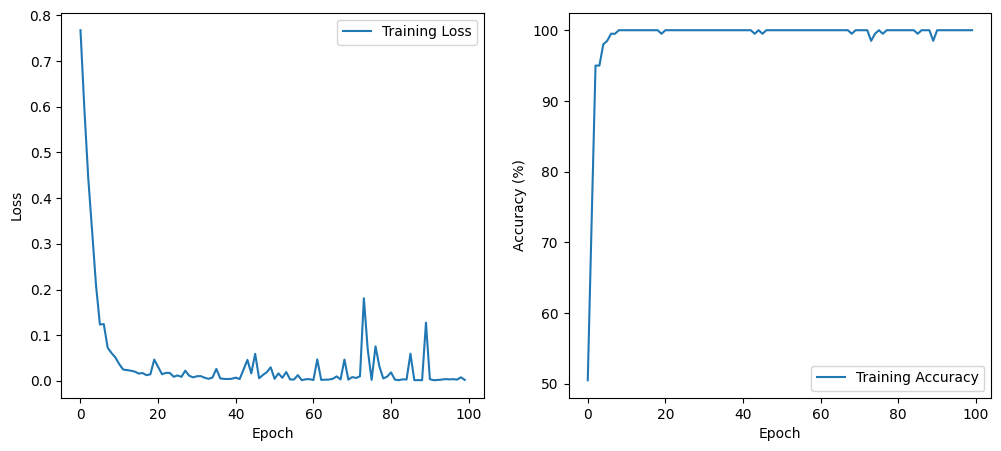

In [54]:
# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_list, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

In [71]:
from sklearn.metrics import confusion_matrix

test_data = datasets.ImageFolder(
    "/home/rishabh.mondal/mixup_test/", transform=transform
)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())


print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
)


def evaluate_and_plot(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)

    precision, recall, f1_score, support = precision_recall_fscore_support(
        y_true, y_pred, average="binary"
    )
    plt.figure(figsize=(3, 2))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

Accuracy of the network on the test images: 98 %


Accuracy: 0.984
Precision: 1.0
Recall: 0.9678714859437751
F1 Score: 0.9836734693877551


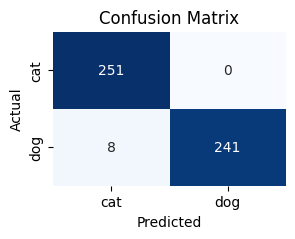

In [72]:
evaluate_and_plot(y_true, y_pred, ["cat", "dog"])

In [74]:
# use model with  mixup
# use model with mixup and also tqdm
from torchvision.transforms import v2

# mixup=v2.MixUp(num_classes=2)
# for images,labels in train_loader:
#     img,labels=mixup(images,labels)
#     print(img.shape)
#     print(labels.shape)
#     break


model1 = models.resnet50(pretrained=True)
model1.to(device)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 2)
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100
loss_list1 = []
acc_list1 = []
for epoch in range(num_epochs):
    model1.train()
    correct = 0
    total = 0
    running_loss = 0.0
    mixup = v2.MixUp(num_classes=2)
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        mixed_images, mixed_labels = mixup(images, labels)
        mixed_images, mixed_labels = mixed_images.to(device), mixed_labels.to(device)
        # print(mixed_images.shape)
        # print(mixed_labels)
        optimizer.zero_grad()
        outputs = model1(mixed_images)
        # print(outputs.shape)
        loss = criterion(outputs, mixed_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        # print(predicted)
        total += mixed_labels.size(0)

        # correct+=(predicted==mixed_labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    # epoch_acc=100*correct/total
    loss_list1.append(epoch_loss)
    acc_list1.append(epoch_acc)
    print("Epoch: %d, Loss: %.3f" % (epoch + 1, running_loss / len(train_loader)))

100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 1, Loss: 0.676


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 2, Loss: 0.668


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 3, Loss: 0.588


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 4, Loss: 0.554


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 5, Loss: 0.431


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 6, Loss: 0.329


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 7, Loss: 0.535


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 8, Loss: 0.509


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


Epoch: 9, Loss: 0.365


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 10, Loss: 0.426


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 11, Loss: 0.326


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 12, Loss: 0.486


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 13, Loss: 0.270


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


Epoch: 14, Loss: 0.406


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 15, Loss: 0.354


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 16, Loss: 0.419


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 17, Loss: 0.455


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 18, Loss: 0.326


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Epoch: 19, Loss: 0.357


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 20, Loss: 0.381


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 21, Loss: 0.354


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 22, Loss: 0.367


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 23, Loss: 0.369


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 24, Loss: 0.265


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch: 25, Loss: 0.537


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 26, Loss: 0.314


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 27, Loss: 0.396


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 28, Loss: 0.413


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 29, Loss: 0.367


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 30, Loss: 0.377


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 31, Loss: 0.395


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 32, Loss: 0.365


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 33, Loss: 0.336


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 34, Loss: 0.434


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch: 35, Loss: 0.344


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 36, Loss: 0.328


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 37, Loss: 0.426


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 38, Loss: 0.400


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 39, Loss: 0.352


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 40, Loss: 0.306


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 41, Loss: 0.448


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 42, Loss: 0.368


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 43, Loss: 0.367


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 44, Loss: 0.413


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 45, Loss: 0.215


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 46, Loss: 0.433


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 47, Loss: 0.316


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 48, Loss: 0.303


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 49, Loss: 0.417


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 50, Loss: 0.263


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch: 51, Loss: 0.320


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 52, Loss: 0.236


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 53, Loss: 0.395


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 54, Loss: 0.342


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 55, Loss: 0.469


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 56, Loss: 0.437


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 57, Loss: 0.348


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 58, Loss: 0.489


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 59, Loss: 0.398


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 60, Loss: 0.432


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 61, Loss: 0.417


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 62, Loss: 0.331


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 63, Loss: 0.465


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 64, Loss: 0.550


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch: 65, Loss: 0.367


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Epoch: 66, Loss: 0.342


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch: 67, Loss: 0.262


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch: 68, Loss: 0.427


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch: 69, Loss: 0.309


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch: 70, Loss: 0.296


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch: 71, Loss: 0.321


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 72, Loss: 0.337


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 73, Loss: 0.285


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 74, Loss: 0.404


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 75, Loss: 0.286


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 76, Loss: 0.494


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch: 77, Loss: 0.275


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 78, Loss: 0.392


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 79, Loss: 0.284


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


Epoch: 80, Loss: 0.405


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch: 81, Loss: 0.275


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 82, Loss: 0.286


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 83, Loss: 0.435


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 84, Loss: 0.324


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 85, Loss: 0.364


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 86, Loss: 0.391


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 87, Loss: 0.444


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 88, Loss: 0.299


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 89, Loss: 0.412


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Epoch: 90, Loss: 0.169


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 91, Loss: 0.486


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 92, Loss: 0.293


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 93, Loss: 0.313


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 94, Loss: 0.462


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 95, Loss: 0.346


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch: 96, Loss: 0.426


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 97, Loss: 0.411


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 98, Loss: 0.436


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch: 99, Loss: 0.460


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

Epoch: 100, Loss: 0.373


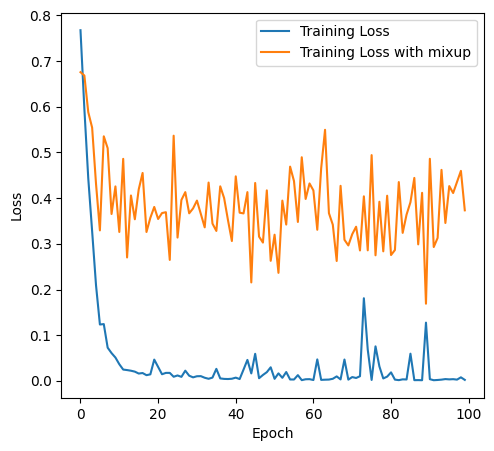

In [75]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label="Training Loss")
plt.plot(loss_list1, label="Training Loss with mixup")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()